<a href="https://colab.research.google.com/github/Gustavoq14/Optimization-Algorithms/blob/main/Benchmarking_DataFitting_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Librerias

In [ ]:
!pip install celluloid
import matplotlib.pyplot as plt
import numpy as np
import numba
import pandas as pd
import math
import time

from scipy.optimize import nnls
from IPython.display import HTML
from celluloid import Camera
from mpl_toolkits.mplot3d import Axes3D

# 2. Funciones

In [ ]:
def chi2(datos, funcion, sigma, params):
  if np.isscalar(sigma) and sigma == 0:
        sigma = 1
  else:
        sigma[sigma == 0] = 1
  return np.sum(np.power((datos-funcion)/sigma,2))/(np.size(datos)-(len(params[0])+len(params[1])))

def grad_chi2(datos, funcion, sigma, gradiente, params):
  return np.array([-2*np.sum((datos - funcion)/np.power(sigma,2)*gradiente[i]) for i in range(len(gradiente))])/(np.size(datos)-(len(params[0])+len(params[1])))

def hess_chi2(datos, funcion, sigma, gradiente, hessiana, params):
  return np.array([[2*np.sum((-datos*hessiana[i][j] + gradiente[i]*gradiente[j] + funcion*hessiana[i][j])/np.power(sigma, 2)) for j in range(hessiana.shape[1])] for i in range(hessiana.shape[0])])/(np.size(datos)-(len(params[0])+len(params[1])))

def funcion_1(x, params):
    t1, t3, t5 = params[0][0], params[0][1], params[0][2]
    t2, t4 = params[1][0], params[1][1]
    return t1*np.cos(t2*x)+t3*np.sin(t4*x)+t5

def bases_1(x, params):
    t2, t4 = params[0], params[1]
    return np.array([np.cos(t2*x), np.sin(t4*x), np.ones_like(x)])

def grad_funcion_1(x, params):
    t1, t3 = params[0][0], params[0][1]
    t2, t4 = params[1][0], params[1][1]
    df_dt2 = -t1*x*np.sin(t2*x)
    df_dt4 = t3*x*np.cos(t4*x)
    return np.array([df_dt2, df_dt4])

def hess_funcion_1(x, params):
    t1, t3 = params[0][0], params[0][1]
    t2, t4 = params[1][0], params[1][1]
    df2_dt22 = -t1*np.power(x,2)*np.cos(t2*x)
    df2_dt2dt4 = np.zeros_like(x)
    df2_dt42 = -t3*np.power(x,2)*np.sin(t4*x)
    return np.array([[df2_dt22, df2_dt2dt4], [df2_dt2dt4, df2_dt42]])

def Bzm(chi_1, chi_2, T):
    return np.exp((chi_1-chi_2)/T)

def T_bath(T):
    if T < 10:
        cte = 1.
    else:
        cte = np.log10(T)
    return T/cte

def Temp(k_c, Tmin, Ti):
    return Ti + k_c * (Tmin - Ti)

def leer_resultados(filename):
    with open(filename, 'r') as file:
        header = file.readline().strip().split('\t')
    data = {col: [] for col in header}
    with open(filename, 'r') as file:
        next(file)
        for line in file:
            values = line.strip().split('\t')
            for col, value in zip(header, values):
                if col in ('beta', 'gamma'):
                    data[col].append([float(v) for v in value.split(', ')])
                elif col in ('chi', 'T'):
                    data[col].append(float(value))
                else:
                    data[col].append(int(value))
    df = pd.DataFrame(data)
    return df

def calculate_limits(data_columns):
    all_data = np.concatenate([df_chi[column].values for column in data_columns])
    x_range = (all_data.min(), all_data.max())
    y_max = max([np.histogram(df_chi[column], bins=30)[0].max() for column in data_columns])
    return x_range, y_max

# 3. Métodos de Ajuste de Datos

## 3.1 Mínimos Cuadrados Lineales

In [ ]:
def coef_lineal(datos, bases, sigma):
    """
    Versión SciPy de NNLS ponderado con misma interfaz que la versión Numba.

    Parameters:
    -----------
    datos : array 1D (n_data,)
        Datos a ajustar
    bases : array 2D (n_bases, n_data)
        Funciones base
    sigma : array 1D (n_data,)
        Desviaciones estándar (pesos)

    Returns:
    --------
    x : array 1D (n_bases,)
        Coeficientes no-negativos o NaN si falla
    """
    try:
        n_data = datos.shape[0]
        n_bases = bases.shape[0]

        # Validación básica de dimensiones
        if bases.shape[1] != n_data or sigma.shape[0] != n_data:
            return np.full(n_bases, np.nan)

        # Validar que sigma y datos sean válidos
        if not np.all(np.isfinite(datos)):
            return np.full(n_bases, np.nan)

        if not np.all(np.isfinite(sigma)) or np.any(sigma <= 0):
            return np.full(n_bases, np.nan)

        if not np.all(np.isfinite(bases)):
            return np.full(n_bases, np.nan)

        # Precalcular inversos de sigma (pesos)
        inv_sigma = 1.0 / sigma

        # Construir matriz ponderada: (n_data, n_bases)
        # bases es (n_bases, n_data), necesitamos transponerla
        A = bases.T * inv_sigma[:, np.newaxis]  # (n_data, n_bases)
        b = datos * inv_sigma                    # (n_data,)

        # Resolver NNLS
        #x, residual = nnls(A, b, maxiter=None)
        x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

        # Verificar que la solución es válida
        if not np.all(np.isfinite(x)):
            return np.full(n_bases, np.nan)

        return x

    except Exception as e:
        n_bases = bases.shape[0]
        return np.full(n_bases, np.nan)

## 3.2 Gradiente Descendiente

In [ ]:
def mc_gd(x, datos, funcion, sigma, bases, gradiente, params_nl, imax = 1000, kmax = 1000, eta = 0.01, tol = 1e-5, filename = 'mc_gd'):
  results = []
  chi = []
  c = 0
  for i in range(imax):
    gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
    B_0 = bases(x, gamma_0)
    beta_0 = coef_lineal(datos, B_0, sigma)
    f_0 = np.sum([beta_0[j]*B_0[j] for j in range(len(beta_0))], axis=0)
    theta_0 = (beta_0, gamma_0)
    theta_opt = theta_0
    chi_opt = chi2(datos, f_0, sigma, theta_0)
    theta_bus = theta_0
    chi_bus = chi2(datos, f_0, sigma, theta_0)

    k = 0
    s = 0
    gamma_k = gamma_0
    beta_k = beta_0
    chi.append(chi_opt)
    dif = 1

    beta_0_str = ", ".join(map(str, theta_0[0]))
    gamma_0_str = ", ".join(map(str, theta_0[1]))
    results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\n")
    while k < kmax and dif > tol:
      grad = grad_chi2(datos, funcion(x, [beta_k, gamma_k]), sigma, gradiente(x, [beta_k, gamma_k]), [beta_k, gamma_k])
      gamma_k -= eta * grad / np.linalg.norm(grad)
      B_k = bases(x, gamma_k)
      beta_k = coef_lineal(datos, B_k, sigma)
      f_k = np.sum([beta_k[j] * B_k[j] for j in range(len(beta_k))], axis=0)
      chi_nue = chi2(datos, f_k, sigma, [beta_k, gamma_k])
      if chi_nue < chi_opt:
        theta_opt = (beta_k.copy(), gamma_k.copy())
        chi_opt = chi_nue
        chi.append(chi_opt)
        s += 1
        dif = abs(chi[s]-chi[s-1])
      beta_k_str = ", ".join(map(str, beta_k.tolist()))
      gamma_k_str = ", ".join(map(str, gamma_k.tolist()))
      results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\n")
      k += 1
  with open(filename, 'w') as file:
    file.write("i\tk\tbeta\tgamma\tchi\n")
    file.writelines(results)

## 3.2 Newton-Rapshon

In [28]:
def mc_nr(x, datos, funcion, sigma, bases, gradiente, hessiana, params_nl, imax = 1000, kmax = 1000, tol = 1e-5, filename = 'mc_nr'):
  results = []
  chi = []
  for i in range(imax):
    gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
    B_0 = bases(x, gamma_0)
    beta_0 = coef_lineal(datos, B_0, sigma)
    f_0 = np.sum([beta_0[j]*B_0[j] for j in range(len(beta_0))], axis=0)
    theta_0 = (beta_0, gamma_0)
    theta_opt = theta_0
    chi_opt = chi2(datos, f_0, sigma, theta_0)
    theta_bus = theta_0
    chi_bus = chi2(datos, f_0, sigma, theta_0)

    k = 0
    s = 0
    gamma_k = gamma_0
    beta_k = beta_0
    chi.append(chi_opt)
    dif = 1

    beta_0_str = ", ".join(map(str, theta_0[0]))
    gamma_0_str = ", ".join(map(str, theta_0[1]))
    results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\n")
    while k < kmax and dif > tol:
      grad = grad_chi2(datos, funcion(x, [beta_k, gamma_k]), sigma, gradiente(x, [beta_k, gamma_k]), [beta_k, gamma_k])
      H = hess_chi2(datos, funcion(x, [beta_k, gamma_k]), sigma, gradiente(x, [beta_k, gamma_k]), hessiana(x, [beta_k, gamma_k]), [beta_k, gamma_k])
      gamma_k -= np.linalg.solve(H, grad)
      B_k = bases(x, gamma_k)
      beta_k = coef_lineal(datos, B_k, sigma)
      f_k = np.sum([beta_k[j] * B_k[j] for j in range(len(beta_k))], axis=0)
      chi_nue = chi2(datos, f_k, sigma, [beta_k, gamma_k])
      if chi_nue < chi_opt:
        theta_opt = (beta_k.copy(), gamma_k.copy())
        chi_opt = chi_nue
        chi.append(chi_opt)
        s += 1
        dif = abs(chi[s] - chi[s-1])
      beta_k_str = ", ".join(map(str, beta_k.tolist()))
      gamma_k_str = ", ".join(map(str, gamma_k.tolist()))
      results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\n")
      k += 1

  with open(filename, 'w') as file:
    file.write("i\tk\tbeta\tgamma\tchi\n")
    file.writelines(results)

## 3.4 Levenberg Marquart

In [ ]:
def mc_lm(x, datos, funcion, sigma, bases, gradiente, hessiana, params_nl, imax=1000, kmax=1000, l=1.0, tol=1e-5, filename='mc_lm'):
    """
    Método de Levenberg–Marquardt Monte Carlo para ajuste mixto lineal/no lineal,
    con criterio de parada y control de lambda mejorados.
    """
    results = []
    chi = []

    for i in range(imax):
        # --- Inicialización aleatoria de parámetros no lineales ---
        gamma = np.array([np.random.uniform(p[0], p[1]) for p in params_nl])
        B = bases(x, gamma)
        beta = coef_lineal(datos, B, sigma)

        f = np.sum([beta[j]*B[j] for j in range(len(beta))], axis=0)
        chi_opt = chi2(datos, f, sigma, [beta, gamma])
        chi_iter = [chi_opt]
        theta_opt = (beta.copy(), gamma.copy())

        # Logging inicial
        beta_str = ", ".join(map(str, beta))
        gamma_str = ", ".join(map(str, gamma))
        results.append(f"{i}\t{0}\t{beta_str}\t{gamma_str}\t{chi_opt}\n")

        for k in range(kmax):
            # --- Gradiente y Hessiana ---
            grad = grad_chi2(datos, funcion(x, [beta, gamma]), sigma, gradiente(x, [beta, gamma]), [beta, gamma])
            H = hess_chi2(datos, funcion(x, [beta, gamma]), sigma, gradiente(x, [beta, gamma]), hessiana(x, [beta, gamma]), [beta, gamma])

            # Paso LM
            I = l * np.eye(H.shape[0])
            try:
                delta = np.linalg.solve(H + I, grad)
            except np.linalg.LinAlgError:
                break  # matriz singular → aborta este intento

            gamma_new = gamma - delta

            # --- Recalcular modelo ---
            B_new = bases(x, gamma_new)
            beta_new = coef_lineal(datos, B_new, sigma)
            f_new = np.sum([beta_new[j]*B_new[j] for j in range(len(beta_new))], axis=0)
            chi_new = chi2(datos, f_new, sigma, [beta_new, gamma_new])

            # --- Criterio de mejora ---
            if chi_new < chi_iter[-1]:
                gamma = gamma_new
                beta = beta_new
                chi_iter.append(chi_new)
                theta_opt = (beta.copy(), gamma.copy())
                chi_opt = chi_new
                l *= 0.5   # ↓ Disminuye lambda (mayor paso)
            else:
                l *= 2.0   # ↑ Aumenta lambda (menor paso)

            # --- Criterios de parada ---
            if np.linalg.norm(delta) < tol:
                break

            # Limitar rango de lambda
            l = min(max(l, 1e-6), 1e4)

            # Logging
            beta_str = ", ".join(map(str, beta.tolist()))
            gamma_str = ", ".join(map(str, gamma.tolist()))
            results.append(f"{i}\t{k}\t{beta_str}\t{gamma_str}\t{chi_new}\n")

        # Guardar el mejor chi² de este ciclo Monte Carlo
        chi.append(chi_opt)

    # --- Escritura de resultados ---
    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\n")
        file.writelines(results)

    return chi

## 3.5 Monte Carlo-Aceptación y Rechazo

In [ ]:
def mc_ar(x, datos, sigma, bases, params_nl, imax = 1000, kmax = 1000, filename='mc_ar'):
  results = []
  for i in range(imax):
    gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
    B_0 = bases(x, gamma_0)
    beta_0 = coef_lineal(datos, B_0, sigma)
    f_0 = np.sum([beta_0[j]*B_0[j] for j in range(len(beta_0))], axis=0)
    theta_0 = (beta_0, gamma_0)
    theta_opt = theta_0
    chi_opt = chi2(datos, f_0, sigma, theta_0)
    theta_bus = theta_0
    chi_bus = chi2(datos, f_0, sigma, theta_0)

    beta_0_str = ", ".join(map(str, theta_0[0]))
    gamma_0_str = ", ".join(map(str, theta_0[1]))
    results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\n")
    for k in range(0, kmax):
      gamma_k = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
      B_k = bases(x, gamma_k)
      beta_k = coef_lineal(datos, B_k, sigma)
      f_k = np.sum([beta_k[j]*B_k[j] for j in range(len(beta_0))], axis=0)
      theta_k = (beta_k, gamma_k)
      theta_bus = theta_k
      chi_nue = chi2(datos, f_k, sigma, theta_k)
      if chi_nue < chi_opt:
        theta_opt = theta_k
        chi_opt = chi_nue
      beta_k_str = ", ".join(map(str, theta_k[0]))
      gamma_k_str = ", ".join(map(str, theta_k[1]))
      results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\n")

  with open(filename, 'w') as file:
    file.write("i\tk\tbeta\tgamma\tchi\n")
    file.writelines(results)

## 3.6 Simulated-Annealing

In [ ]:
def mc_sa(x, datos, sigma, bases, params_nl, target, imax=1000, t0 = 1000, kmax=1000, alpha = 0.99, filename="mc_sa"):
    results = []
    for i in range(imax):
        if i % 100 == 0:
          gamma_0 = target
        else:
          gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
        B_0 = bases(x, gamma_0)
        beta_0 = coef_lineal(datos, B_0, sigma)
        f_0 = np.dot(beta_0, B_0)
        theta_0 = (beta_0, gamma_0)

        theta_opt = theta_0
        chi_opt = chi2(datos, f_0, sigma, theta_0)
        theta_bus = theta_0
        chi_bus = chi2(datos, f_0, sigma, theta_0)
        T = t0

        beta_0_str = ", ".join(map(str, theta_0[0]))
        gamma_0_str = ", ".join(map(str, theta_0[1]))
        results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\t{T}\n")

        for k in range(kmax):
            gamma_k = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
            B_k = bases(x, gamma_k)
            beta_k = coef_lineal(datos, B_k, sigma)
            f_k = np.dot(beta_k, B_k)
            theta_k = (beta_k, gamma_k)
            theta_bus = theta_k
            chi_nue = chi2(datos, f_k, sigma, theta_k)

            if chi_nue < chi_opt:
                chi_opt = chi_nue
                theta_opt = theta_k
            else:
                if np.random.uniform(0, 1) < Bzm(chi_nue, chi_opt, T):
                    chi_opt = chi_nue
                    theta_opt = theta_k


            beta_k_str = ", ".join(map(str, theta_k[0]))
            gamma_k_str = ", ".join(map(str, theta_k[1]))
            results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\t{T}\n")
            T *= alpha
    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\tT\n")
        file.writelines(results)

## 3.7 Self-Cooling Simulated-Annealing

In [ ]:
def mc_scsa(x, datos, sigma, make_bases, params_nl, d, k_c= None, imax=1000, kmax=1000, filename='mc_scsa'):
    if k_c is None:
        k_c = 5/kmax

    results = []
    var = [(params_nl[j][1] - params_nl[j][0])*0.5 for j in range(len(params_nl))]

    chi_min_global = np.inf
    theta_min_global = None

    for i in range(imax):

        # inicio del ciclo i
        inicio_i = time.time()

        gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
        B_0 = make_bases(x, gamma_0, d)
        beta_0 = coef_lineal(datos, B_0, sigma)
        f_0 = np.dot(beta_0, B_0)
        theta_0 = (beta_0, gamma_0)

        # Estado actual de la cadena
        theta_actual = theta_0
        chi_actual = chi2(datos, f_0, sigma, theta_0)

        chi_min_cadena = chi_actual

        # Actualizar mínimo global
        if chi_min_cadena < chi_min_global:
            chi_min_global = chi_actual
            theta_min_global = theta_actual

        # Temperatura inicial
        T_ext = T_bath(chi_min_cadena)
        T = T_ext*1.5

        beta_0_str = ",".join(map(str, theta_0[0]))
        gamma_0_str = ",".join(map(str, theta_0[1]))
        results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_actual}\t{T}\n")

        for k in range(kmax):

            inicio_k = time.time()  # inicio del ciclo k

            gamma_k = np.array([np.random.normal(theta_actual[1][j], var[j])
                                for j in range(len(var))])
            while not np.all([limite[0] <= valor <= limite[1]
                              for valor, limite in zip(gamma_k, params_nl)]):
                gamma_k = np.array([np.random.normal(theta_actual[1][j], var[j])
                                    for j in range(len(var))])

            B_k = make_bases(x, gamma_k, d)
            beta_k = coef_lineal(datos, B_k, sigma)
            f_k = np.dot(beta_k, B_k)
            theta_k = (beta_k, gamma_k)

            chi_k = chi2(datos, f_k, sigma, theta_k)
            # Criterio de aceptación
            if chi_k < chi_actual:
                # Siempre aceptar si mejora
                chi_actual = chi_k
                theta_actual = theta_k

                # Actualizar mínimo de la cadena
                if chi_k < chi_min_cadena:
                    chi_min_cadena = chi_k
                    T_ext = T_bath(chi_min_cadena)
                    # Actualizar mínimo global
                    if chi_k < chi_min_global:
                        chi_min_global = chi_k
                        theta_min_global = theta_k

            else:
                if np.random.uniform(0, 1) < Bzm(chi_k, chi_actual, T):
                    chi_actual = chi_k
                    theta_actual = theta_k

            beta_k_str = ",".join(map(str, theta_k[0]))
            gamma_k_str = ",".join(map(str, theta_k[1]))
            results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_k}\t{T}\n")

            T = Temp(k_c, T_ext, T)

    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\tT\n")
        file.writelines(results)

## 3.8 Self-Cooling Simulated-Annealing  Variable Variance

In [ ]:
def mc_scsav(x, datos, sigma, bases, params_nl, target, k_c=0.1, imax=1000, kmax=1000, std_number=3, n=5, filename='mc_scsav'):
    results = []
    initial_var = [(params_nl[j][1] - params_nl[j][0]) * 0.1 for j in range(len(params_nl))]
    accepted_solutions = np.zeros((std_number, len(params_nl)))
    acceptance_counter = 0

    for i in range(imax):
        if i % 100 == 0:
            gamma_0 = target
        else:
            gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])

        B_0 = bases(x, gamma_0)
        beta_0 = coef_lineal(datos, B_0, sigma)
        f_0 = np.dot(beta_0, B_0)
        theta_0 = (beta_0, gamma_0)
        theta_opt = theta_0
        chi_opt = chi2(datos, f_0, sigma, theta_0)
        theta_bus = theta_0
        chi_bus = chi_opt

        # Temperatura inicial como en mc_scsa
        T_ext = T_bath(chi_opt)
        T = T_ext * 1.5
        var = initial_var.copy()

        beta_0_str = ", ".join(map(str, theta_0[0]))
        gamma_0_str = ", ".join(map(str, theta_0[1]))
        results.append(f"{i}\t0\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\t{T}\n")

        for k in range(kmax):
            gamma_k = np.array([np.random.normal(theta_bus[1][j], var[j]) for j in range(len(var))])
            while not np.all([limite[0] <= valor <= limite[1] for valor, limite in zip(gamma_k, params_nl)]):
                gamma_k = np.array([np.random.normal(theta_bus[1][j], var[j]) for j in range(len(var))])

            B_k = bases(x, gamma_k)
            beta_k = coef_lineal(datos, B_k, sigma)
            f_k = np.dot(beta_k, B_k)
            theta_k = (beta_k, gamma_k)
            chi_nue = chi2(datos, f_k, sigma, theta_k)

            # Criterio de aceptación
            if chi_nue < chi_opt:
                chi_opt = chi_nue
                theta_opt = theta_k
                T_ext = T_bath(chi_opt)  # actualizar T_ext como en mc_scsa
                accepted_solutions[acceptance_counter % std_number] = gamma_k
                acceptance_counter += 1
            else:
                if np.random.uniform(0, 1) < Bzm(chi_nue, chi_opt, T):
                    chi_opt = chi_nue
                    theta_opt = theta_k
                    accepted_solutions[acceptance_counter % std_number] = gamma_k
                    acceptance_counter += 1

            if acceptance_counter >= std_number:
                var = np.std(accepted_solutions, axis=0) * n  # ajuste de varianza adaptativa

            beta_k_str = ", ".join(map(str, theta_k[0]))
            gamma_k_str = ", ".join(map(str, theta_k[1]))
            results.append(f"{i}\t{k+1}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\t{T}\n")

            # Actualización de temperatura paso a paso
            T = Temp(k_c, T_ext, T)

    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\tT\n")
        file.writelines(results)

# 4. Datos de prueba.

Los datos utilizados para testear los distintos métodos son simulados a partir de un modelo seleccionado según la ecuación.

$$y(x)=\theta_1\cos(\theta_2x)+\theta_3\sin(\theta_4x)+\theta_5$$

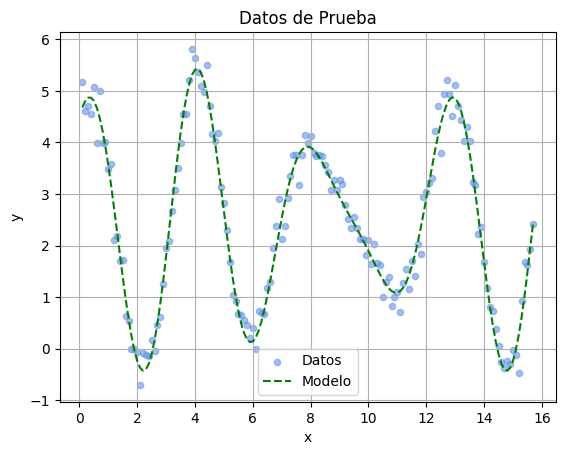

In [ ]:
np.random.seed(1)
params_funcion1 = ([2, 1, 2.5], [1.5, 2])
x_funcion1 = np.arange(0.1, 5*np.pi, 0.1)
y_funcion1 = funcion_1(x_funcion1, params_funcion1)
datos_funcion1 = np.random.normal(y_funcion1, 0.3)
sigma_funcion1 = y_funcion1-datos_funcion1
chi_funcion1 = chi2(datos_funcion1, y_funcion1, sigma_funcion1, params_funcion1)

fig = plt.figure()

plt.scatter(x_funcion1, datos_funcion1, s = 20, alpha = 0.6, color = 'cornflowerblue', label = 'Datos')
plt.plot(x_funcion1, y_funcion1, '--', color = 'green', label ='Modelo')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Datos de Prueba')
plt.grid()
plt.legend()

plt.show()

# 8. Testeo de Métodos

Todos los métodos fueron testeados con 1000 reinicios

In [23]:
tiempo = []
params_nl_funcion1 = [(0.0, 3.0), (0.0, 5.0)]

In [24]:
inicio = time.time()
mc_gd(x_funcion1, datos_funcion1, funcion_1, sigma_funcion1, bases_1, grad_funcion_1, params_nl_funcion1, eta = 0.001)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio: .4}s')

Tiempo de ejecución:  173.8s


In [29]:
inicio = time.time()
mc_nr(x_funcion1, datos_funcion1, funcion_1, sigma_funcion1, bases_1, grad_funcion_1, hess_funcion_1, params_nl_funcion1)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución {fin-inicio:.4}s')

Tiempo de ejecución 326.9s


In [30]:
inicio = time.time()
mc_lm(x_funcion1, datos_funcion1, funcion_1, sigma_funcion1, bases_1, grad_funcion_1, hess_funcion_1, params_nl_funcion1)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio:.4}s')

Tiempo de ejecución: 383.2s


In [31]:
inicio = time.time()
mc_ar(x_funcion1, datos_funcion1, sigma_funcion1, bases_1, params_nl_funcion1)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución {fin-inicio: .4}s')

Tiempo de ejecución  122.4s


In [32]:
inicio = time.time()
mc_sa(x_funcion1, datos_funcion1, sigma_funcion1, bases_1, params_nl_funcion1)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio: .4}s')

TypeError: mc_sa() missing 1 required positional argument: 'target'

In [ ]:
inicio = time.time()
mc_scsa(x_funcion1, datos_funcion1, sigma_funcion1, bases_1, params_nl_funcion1, std_number = 5)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio: .4}s')

In [ ]:
inicio = time.time()
mc_scsav(x_funcion1, datos_funcion1, sigma_funcion1, bases_1, params_nl_funcion1, std_number = 5)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio: .4}s')

Tiempo de ejecución:  399.3s
